In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Step 1: import libraries 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import numpy as np
import nltk
import requests
from itertools import chain

# Step 2: Prepare the corpus
### Load, tokenize, and preprocess the Reuters dataset.
### Build the vocab, inverse mapping and numericalise the dataset

In [3]:
import requests
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import random
from collections import Counter

In [4]:
# Download necessary NLTK resources
nltk.download('punkt') 

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

# Prepare the dataset
response = requests.get(url)
raw_text = response.text

# Define markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"

# Find the start and end positions
start_idx = raw_text.find(start_marker) + len(start_marker)
end_idx = raw_text.find(end_marker)

# Slice out the actual content
text = raw_text[start_idx:end_idx].strip()

[nltk_data] Downloading package punkt to /Users/xiaoxuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#---For checking---
print(f"Extracted text length: {len(text)} characters")
print("Preview:\n", text[:1000])  # Show first 1000 characters
### End of checking

Extracted text length: 5555356 characters
Preview:
 The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PR

In [6]:
# Tokenize text into sentences, then words
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
tokenized_sentences = [  # Remove punctuation and numbers to keep alphabetic words only
    [word for word in sentence if word.isalpha() and len(word) > 1]  # Also remove single letters
    for sentence in tokenized_sentences
]

total_words = sum(len(sentence) for sentence in tokenized_sentences)
print(f"Total sentences: {len(tokenized_sentences)}") #104698
print(f"Total words: {total_words}") #911436

# Check first 5 sentences
print("\nFirst 5 tokenized sentences:")
for i, sentence in enumerate(tokenized_sentences[:5]):
    print(f"{i+1}: {' '.join(sentence)}")

Total sentences: 104698
Total words: 911436

First 5 tokenized sentences:
1: the complete works of william shakespeare by william shakespeare contents the sonnets all well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear love labour lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor midsummer night dream much ado about nothing the tragedy of othello the moor of venice pericles prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the te

In [7]:
# Split the Gutenberg text into train/val/test: 80/10/10
random.seed(42)
random.shuffle(tokenized_sentences)  # Shuffle sentences for better distribution

total_sentences = len(tokenized_sentences)
train_size = int(total_sentences * 0.8)
val_size = int(total_sentences * 0.1)
#test_size = remaining 10%

# Split the data
train_data_sentences = tokenized_sentences[:train_size]
val_data_sentences = tokenized_sentences[train_size:train_size + val_size]
test_data_sentences = tokenized_sentences[train_size + val_size:]

print(f"\nDataset split:")
print(f"Train sentences: {len(train_data_sentences)}") #Train sentences: 83758
print(f"Val sentences: {len(val_data_sentences)}") #Val sentences: 10469
print(f"Test sentences: {len(test_data_sentences)}") #Test sentences: 10471


Dataset split:
Train sentences: 83758
Val sentences: 10469
Test sentences: 10471


In [11]:
# Build vocabulary from training data only
counter = Counter(token for sentence in train_data_sentences for token in sentence)
print(f"Unique words in training data: {len(counter)}") #Unique words in training data: 22006

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=4)}
vocab.update({"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3})

# Create inverse vocabulary mapping
inv_vocab = {idx: word for word, idx in vocab.items()}

#print(f"Final vocabulary size: {len(vocab)}") #Final vocabulary size: 22006

Unique words in training data: 22006


In [12]:
# Numericalize data: Convert words to IDs
def numericalize(data, vocab):
    numericalized = []
    for sentence in data:
        # Add <bos> at start and <eos> at end
        numericalized.append([vocab["<bos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence] + [vocab["<eos>"]])
    return numericalized

# Convert all splits to numerical format
train_data = numericalize(train_data_sentences, vocab)
val_data = numericalize(val_data_sentences, vocab)
test_data = numericalize(test_data_sentences, vocab)

In [13]:
########FOR CHECKING######

# Check the numericalized data
print(f"\nNumericalized data sample:")
print(f"Original sentence: {' '.join(train_data_sentences[0])}")
print(f"Numericalized: {train_data[0][:10]}...")  # Show first 10 tokens

# Check average sentence lengths
train_lengths = [len(sentence) for sentence in train_data]
val_lengths = [len(sentence) for sentence in val_data]
test_lengths = [len(sentence) for sentence in test_data]

# Print some Dataset statistics
print(f"\nAverage sentence lengths:")
print(f"Train: {sum(train_lengths)/len(train_lengths):.1f} tokens") #10.7 tokens
print(f"Val: {sum(val_lengths)/len(val_lengths):.1f} tokens") #10.8 tokens
print(f"Test: {sum(test_lengths)/len(test_lengths):.1f} tokens") #10.6 tokens
print(f"- Total vocabulary size: {len(vocab):,}") #Total vocabulary size: 22,010
print(f"- Training sentences: {len(train_data):,}") #Training sentences: 83,758
print(f"- Validation sentences: {len(val_data):,}") #Validation sentences: 10,469
print(f"- Test sentences: {len(test_data):,}") #Test sentences: 10,471
print(f"- Total training tokens: {sum(len(s) for s in train_data):,}") #Total training tokens: 896,922
print(f"- Total validation tokens: {sum(len(s) for s in val_data):,}") #Total validation tokens: 112,618
print(f"- Total test tokens: {sum(len(s) for s in test_data):,}") #Total test tokens: 111,292


Numericalized data sample:
Original sentence: that were to blow at fire in hope to quench it for who digs hills because they do aspire throws down one mountain to cast up higher
Numericalized: [2, 11, 87, 6, 1026, 51, 383, 10, 292, 6]...

Average sentence lengths:
Train: 10.7 tokens
Val: 10.8 tokens
Test: 10.6 tokens
- Total vocabulary size: 22,010
- Training sentences: 83,758
- Validation sentences: 10,469
- Test sentences: 10,471
- Total training tokens: 896,922
- Total validation tokens: 112,618
- Total test tokens: 111,292


In [14]:
# Show most common words
print("\nTop 10 most common words:")
for word, count in counter.most_common(10):
    print(f"{word}: {count}")
#ANS: the, and, to, of, you, my, in, that, is, not


Top 10 most common words:
the: 24295
and: 22729
to: 16670
of: 14868
you: 11736
my: 10506
in: 9972
that: 9792
not: 7918
is: 7914


# SECTION A: RNN Base Model

## Step 3: Define Dataset and DataLoader

In [15]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
    

In [16]:
# Hyperparameters
seq_len = 128

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## Step 4: Build the RNN Model

In [17]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [18]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [19]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [20]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.35it/s]


Epoch 1 | Train Loss: 9.7245 | Train PPL: 16722.84 | Val Loss: 9.7793 | Val PPL: 17664.50 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.42it/s]


Epoch 2 | Train Loss: 8.5414 | Train PPL: 5122.71 | Val Loss: 8.5102 | Val PPL: 4965.17 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.29it/s]


Epoch 3 | Train Loss: 6.9921 | Train PPL: 1088.00 | Val Loss: 7.8754 | Val PPL: 2631.79 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.40it/s]


Epoch 4 | Train Loss: 6.2467 | Train PPL: 516.31 | Val Loss: 7.8839 | Val PPL: 2654.31 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.35it/s]


Epoch 5 | Train Loss: 5.8544 | Train PPL: 348.77 | Val Loss: 7.9554 | Val PPL: 2850.87 | LR: 0.000500


Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.42it/s]


Epoch 6 | Train Loss: 5.6779 | Train PPL: 292.33 | Val Loss: 7.9385 | Val PPL: 2803.15 | LR: 0.000500


Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.44it/s]


Epoch 7 | Train Loss: 5.5315 | Train PPL: 252.52 | Val Loss: 7.8856 | Val PPL: 2658.74 | LR: 0.000250


Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.37it/s]


Epoch 8 | Train Loss: 5.4105 | Train PPL: 223.75 | Val Loss: 7.8607 | Val PPL: 2593.25 | LR: 0.000250


Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.42it/s]


Epoch 9 | Train Loss: 5.3412 | Train PPL: 208.76 | Val Loss: 7.8402 | Val PPL: 2540.81 | LR: 0.000250


Training Epoch 10: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:18<00:00,  1.26it/s]


Epoch 10 | Train Loss: 5.2827 | Train PPL: 196.90 | Val Loss: 7.8218 | Val PPL: 2494.47 | LR: 0.000250
Total training time: 2.97 minutes


In [21]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1    9.724531  16722.841895  9.779313      17664.5046
Epoch 2    8.541439   5122.712948  8.510203     4965.168923
Epoch 3    6.992099   1088.003177  7.875419     2631.788796
Epoch 4    6.246716     516.31443   7.88394     2654.310549
Epoch 5    5.854424    348.773941  7.955378     2850.866727
Epoch 6    5.677886    292.330804  7.938498     2803.147876
Epoch 7    5.531481    252.517659  7.885607     2658.739543
Epoch 8    5.410513    223.746244  7.860668     2593.253057
Epoch 9    5.341167    208.756259  7.840238     2540.810199
Epoch 10   5.282678      196.8965  7.821831     2494.468452
10              ---           ---       ---  Time: 2.97 min


## Step 6: Plot training and validation loss curves

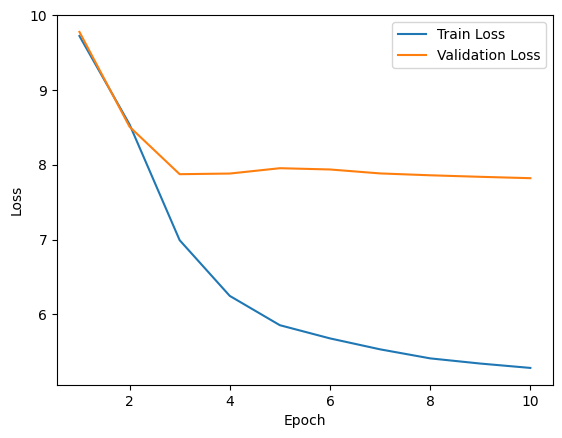

In [22]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [23]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [24]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 7.8218, Test PPL: 2494.4685
Test Loss: 9.0122, Test PPL: 8202.7299


We can still see that the test perplexity is still very large as compared to validation loss, showing a huge generalisation gap.

## Step 8: Generate Text 

In [25]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [26]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the third the first of keep that the two the first the tempest of the chine of the moor of windsor king keeper the tragedy in not and the second of heralds the tragedy of windsor the montgomery and julius what own the titus of you queen the of of sex the tragedy of king henry verona the to the sister of king henry the tragedy of the tragedy of no to st cranmer to the as of to henry the you of called john gaolers part of king hand attendant land you the tragedy of and the tragedy of took thy and to to thy fed their the tenor the two of the two and earl of out raise duke of sweet the tragedy of the fashions of royal or of king the tragedy of king the nature of the tragedy of with forgot lord royal then the tragedy
[Sampling with T=1.0] 
the respecting six shrew king three for and it helena of with high the ebbing athens fortune thee dust by earl of the interlude of what montague were widows of horrid sir every tribunes own scene ewe is gull lampass and hippolyta yo

# SECTION B: ABLATION STUDY ON DROPOUT = 0.1

## Steps 1 - 3 are the same as above
## Step 4: Build the RNN Model

In [31]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True) #, dropout=dropout if num_layers > 1 else 0.0)
        #self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        #output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [32]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [33]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [34]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.28it/s]


Epoch 1 | Train Loss: 9.6911 | Train PPL: 16172.50 | Val Loss: 9.7299 | Val PPL: 16812.37 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.32it/s]


Epoch 2 | Train Loss: 8.3833 | Train PPL: 4373.59 | Val Loss: 8.4514 | Val PPL: 4681.68 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.34it/s]


Epoch 3 | Train Loss: 6.8978 | Train PPL: 990.07 | Val Loss: 7.9583 | Val PPL: 2859.07 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.34it/s]


Epoch 4 | Train Loss: 6.1559 | Train PPL: 471.50 | Val Loss: 8.0429 | Val PPL: 3111.70 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.31it/s]


Epoch 5 | Train Loss: 5.7928 | Train PPL: 327.93 | Val Loss: 8.0574 | Val PPL: 3157.08 | LR: 0.000500


Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:18<00:00,  1.27it/s]


Epoch 6 | Train Loss: 5.6224 | Train PPL: 276.55 | Val Loss: 8.0412 | Val PPL: 3106.42 | LR: 0.000500


Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.34it/s]


Epoch 7 | Train Loss: 5.4908 | Train PPL: 242.46 | Val Loss: 7.9764 | Val PPL: 2911.45 | LR: 0.000250


Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.35it/s]


Epoch 8 | Train Loss: 5.3753 | Train PPL: 216.00 | Val Loss: 7.9323 | Val PPL: 2785.75 | LR: 0.000250


Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.42it/s]


Epoch 9 | Train Loss: 5.3278 | Train PPL: 205.99 | Val Loss: 7.9241 | Val PPL: 2763.09 | LR: 0.000250


Training Epoch 10: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.37it/s]


Epoch 10 | Train Loss: 5.2746 | Train PPL: 195.31 | Val Loss: 7.9093 | Val PPL: 2722.46 | LR: 0.000250
Total training time: 3.04 minutes


In [35]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)


         Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1    9.691068  16172.501718   9.72987     16812.36713
Epoch 2     8.38334   4373.594016  8.451412     4681.678202
Epoch 3    6.897772    990.066431  7.958251      2859.06752
Epoch 4    6.155923    471.501639  8.042923     3111.695314
Epoch 5    5.792811    327.933558  8.057404     3157.082323
Epoch 6    5.622374    276.545099  8.041226     3106.420529
Epoch 7    5.490819    242.455621  7.976406     2911.448776
Epoch 8    5.375276    215.999463  7.932272      2785.74952
Epoch 9     5.32783    205.990405  7.924105     2763.091272
Epoch 10   5.274598    195.311945  7.909292     2722.463402
10              ---           ---       ---  Time: 3.04 min


## Step 6: Plot training and validation loss curves

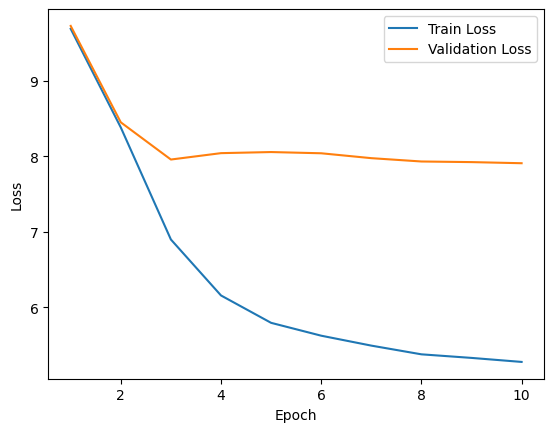

In [36]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [37]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [38]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 7.9093, Test PPL: 2722.4634
Test Loss: 9.1155, Test PPL: 9095.3240


## Step 8: Generate Text 

In [39]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [40]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the maincourse of the tragedy of swallowing all of your the and of othello of king and the tragedy the lord of safety and the ewe ambassador of buckingham king henry the merchant of be the porter of is the tragedy of your of of the oppress and of venice henry the swarm of rutland king the this of thebes the with of timon to the tragedy and his these queens the two of the duke of the jailer and to the merry the shrew of the rise of windsor in the french and by to his and the shrew as the world to his the wronger of king clifford spring the dumb of the he of king of war france high less the him of the riper so the merchant in the staggers or to the third of forgot of king york the wast the that mace dream cleopatra
[Sampling with T=1.0] 
the tragedy the guard of gentlemen drumble earth york midnight smear the life woo winds doncaster all sister valerius isle hey in the winter in made to news queen cleopatra of might upon of fore had duke which earl the two to to qu

# SECTION C: ABLATION STUDY ON CONTEXT LENGTH = 256

## Steps 1 - 2 are the same as above

## Step 3: Define Dataset and DataLoader

In [40]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [46]:
# Hyperparameters
seq_len = 64

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## Step 4: Build the RNN Model

In [47]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## Step 5: Train the Model

In [48]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [49]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 10
grad_accum_steps = 4
import time

In [50]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 1: 100%|███████████████████████████████████████████████████████████████| 318/318 [02:07<00:00,  2.50it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 1 | Train Loss: 7.3768 | Train PPL: 1598.53 | Val Loss: 7.5711 | Val PPL: 1941.21 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 2: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:49<00:00,  2.92it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 2 | Train Loss: 6.4450 | Train PPL: 629.55 | Val Loss: 7.4793 | Val PPL: 1770.95 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 3: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:43<00:00,  3.07it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 3 | Train Loss: 5.7329 | Train PPL: 308.87 | Val Loss: 7.3743 | Val PPL: 1594.42 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 4: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:44<00:00,  3.06it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 4 | Train Loss: 4.8515 | Train PPL: 127.93 | Val Loss: 7.4014 | Val PPL: 1638.34 | LR: 0.001000


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 5: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:47<00:00,  2.97it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 5 | Train Loss: 3.9611 | Train PPL: 52.51 | Val Loss: 7.5193 | Val PPL: 1843.29 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 6: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:47<00:00,  2.95it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 6 | Train Loss: 3.3529 | Train PPL: 28.59 | Val Loss: 7.6058 | Val PPL: 2009.78 | LR: 0.000500


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 7: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:39<00:00,  3.19it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 7 | Train Loss: 3.0097 | Train PPL: 20.28 | Val Loss: 7.6986 | Val PPL: 2205.16 | LR: 0.000250


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 8: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:40<00:00,  3.18it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 8 | Train Loss: 2.7698 | Train PPL: 15.96 | Val Loss: 7.7484 | Val PPL: 2317.82 | LR: 0.000250


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 9: 100%|███████████████████████████████████████████████████████████████| 318/318 [01:52<00:00,  2.82it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 9 | Train Loss: 2.6234 | Train PPL: 13.78 | Val Loss: 7.8016 | Val PPL: 2444.57 | LR: 0.000125


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Training Epoch 10: 100%|██████████████████████████████████████████████████████████████| 318/318 [01:52<00:00,  2.83it/s]


RNNLanguageModel(
  (embedding): Embedding(22010, 128, padding_idx=1)
  (rnn): RNN(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=22010, bias=True)
)

Epoch 10 | Train Loss: 2.5196 | Train PPL: 12.42 | Val Loss: 7.8235 | Val PPL: 2498.52 | LR: 0.000125
Total training time: 19.01 minutes


In [51]:
# Create a table for all values

#import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss    Train PPL  Val Loss          Val PPL
Epoch 1    7.376839  1598.528494  7.571069      1941.214877
Epoch 2    6.445003   629.548767  7.479272      1770.950713
Epoch 3    5.732917   308.868831  7.374267      1594.422269
Epoch 4    4.851465    127.92765  7.401438      1638.338473
Epoch 5    3.961063    52.513108   7.51931      1843.294453
Epoch 6    3.352945    28.586807  7.605778      2009.775694
Epoch 7     3.00969    20.281118  7.698557      2205.163916
Epoch 8    2.769793    15.955339  7.748381      2317.816608
Epoch 9    2.623394    13.782427  7.801626      2444.573209
Epoch 10   2.519625    12.423938  7.823454      2498.520473
10              ---          ---       ---  Time: 19.01 min


## Step 6: Plot training and validation loss curves


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

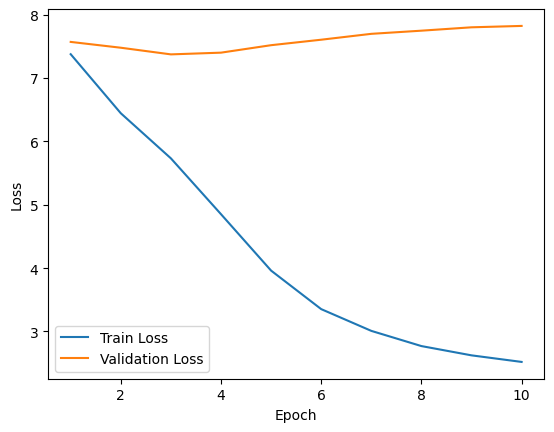

In [52]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the Model

In [39]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation


In [54]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 7.8235, Test PPL: 2498.5205
Test Loss: 8.0073, Test PPL: 3002.8056


## Step 8: Generate Text

In [55]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [56]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the todpole the sinews and all to the listening of that fair the heavens the wanton and such upon the fear of scorn to some small distance follows gentleman bearing of timon creditors lucius servant of timon creditors philotus servant of timon creditors servant of timon creditors philotus servant of timon creditors lucius servant of timon creditors servant of isidore two servants of varro titus servant of timon creditors hortensius servant of timon creditors servant of isidore two servants of varro titus servant of timon creditors philotus servant of timon creditors servant of timon creditors lucius servant of timon creditors servant of timon creditors lucius servant of isidore two servants of varro titus servant of timon creditors servant to king richard earl of warwick earl of pembroke lord hastings lord stafford sir john mortimer uncle to the combat in the queen of your country justice in the night that all
[Sampling with T=1.0] 
the seaman shrieked the romans

# SECTION D: LTSM Base Model

## Steps 1-2 once again

In [ ]:
train_data
val_data
test_data

## Step 3: Define Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class ShakespheareLSTMDataset(Dataset):
    def __init__(self, data, pad_idx, max_len=128):
        """
        data: list of numericalized sentences (list of lists)
        pad_idx: index of <pad>
        max_len: maximum sequence length
        """
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][:-1]   # input: all except last token
        y = self.data[idx][1:]    # target: all except first token

        # Pad or truncate
        x = x[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(x))
        y = y[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(y))

        return torch.tensor(x), torch.tensor(y)

In [ ]:
pad_idx = vocab["<pad>"]
batch_size = 32
train_dataset = ShakespheareLSTMDataset(train_data, pad_idx)
val_dataset = ShakespheareLSTMDataset(val_data, pad_idx)
test_dataset = ShakespheareLSTMDataset(test_data, pad_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader(DataLoader(test_dataset, batch_size=batch_size)

## Step 4: Create LSTM Model

In [74]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)          # (batch, seq_len, embed_size)
        output, hidden = self.lstm(x, hidden)  # (batch, seq_len, hidden_size)
        logits = self.fc(output)       # (batch, seq_len, vocab_size)
        return logits, hidden

## Step 5: Train the Model

In [75]:
# ----- Hyperparameters -----
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.3
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 10
grad_accum_steps = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Initialize Model -----
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"], dropout=dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

In [76]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

In [77]:
# ----- Training Loop -----
start_time = time.time()

for epoch in range(num_epochs):
    ## ----- Training -----
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        # Gradient accumulation
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    # Scheduler step
    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [47:09<00:00,  2.16s/it]


Epoch 1 | Train Loss: 6.4984 | Train PPL: 664.08 | Val Loss: 6.0831 | Val PPL: 438.39 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [46:36<00:00,  2.14s/it]


Epoch 2 | Train Loss: 5.8936 | Train PPL: 362.69 | Val Loss: 5.8573 | Val PPL: 349.79 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:28<00:00,  1.86s/it]


Epoch 3 | Train Loss: 5.6911 | Train PPL: 296.23 | Val Loss: 5.7601 | Val PPL: 317.40 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:12<00:00,  1.84s/it]


Epoch 4 | Train Loss: 5.5565 | Train PPL: 258.93 | Val Loss: 5.7028 | Val PPL: 299.71 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:00<00:00,  1.83s/it]


Epoch 5 | Train Loss: 5.4470 | Train PPL: 232.06 | Val Loss: 5.6648 | Val PPL: 288.53 | LR: 0.001000


Training Epoch 6: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:08<00:00,  1.84s/it]


Epoch 6 | Train Loss: 5.3532 | Train PPL: 211.29 | Val Loss: 5.6431 | Val PPL: 282.33 | LR: 0.001000


Training Epoch 7: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:07<00:00,  1.84s/it]


Epoch 7 | Train Loss: 5.2655 | Train PPL: 193.54 | Val Loss: 5.6305 | Val PPL: 278.81 | LR: 0.001000


Training Epoch 8: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:17<00:00,  1.85s/it]


Epoch 8 | Train Loss: 5.1836 | Train PPL: 178.32 | Val Loss: 5.6242 | Val PPL: 277.06 | LR: 0.001000


Training Epoch 9: 100%|█████████████████████████████████████████████████████████████| 1309/1309 [40:49<00:00,  1.87s/it]


Epoch 9 | Train Loss: 5.1102 | Train PPL: 165.70 | Val Loss: 5.6227 | Val PPL: 276.63 | LR: 0.001000


Training Epoch 10: 100%|████████████████████████████████████████████████████████████| 1309/1309 [40:24<00:00,  1.85s/it]


Epoch 10 | Train Loss: 5.0354 | Train PPL: 153.76 | Val Loss: 5.6253 | Val PPL: 277.35 | LR: 0.001000
Total training time: 431.38 minutes


In [78]:
# Create a table for all values

#import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

         Train Loss   Train PPL  Val Loss           Val PPL
Epoch 1    6.498398  664.076635  6.083117        438.393369
Epoch 2    5.893553  362.691645  5.857321        349.785946
Epoch 3    5.691148  296.233488  5.760148        317.395265
Epoch 4    5.556549  258.927648  5.702813         299.70938
Epoch 5    5.447007  232.062597  5.664788        288.526924
Epoch 6     5.35324  211.291829  5.643084        282.332119
Epoch 7      5.2655  193.543125  5.630538        278.811995
Epoch 8    5.183583  178.320633  5.624244        277.062777
Epoch 9    5.110184  165.700814  5.622675        276.628494
Epoch 10   5.035368   153.75623  5.625286        277.351538
10              ---         ---       ---  Time: 431.38 min


## Step 6: Plot training and validation loss curves

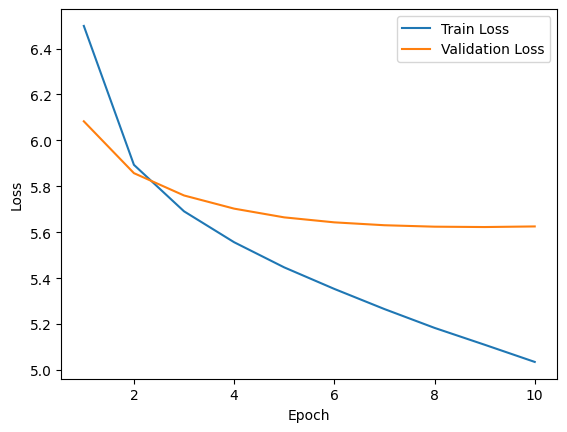

In [79]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7: Evaluate the model

In [80]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [81]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Perplexity: 277.3515, Test Perplexity: 675.0912


## Step 8: Generate Text¶

In [82]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        if next_token == vocab["<eos>"]:
            break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [84]:
def generate_text(model, start_seq, max_len=1000, temperature=1, max_words=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()

        #if next_token == vocab["<eos>"]:
            #break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [85]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))
    

[Sampling with T=0.7] 
the riping have been on <eos> simple <eos> and that are not too long <eos> <eos> to serve my soul <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> and all this the truth and these tears are quite even in thy face <eos> <eos> eyes <eos> death <eos> wriothesley and so <eos> by thinking of book be quite than gentlewoman should be in the city of thee <eos> <eos> <eos> <eos> than thou art their drum in the field <eos> <eos> <eos> <eos> when you have done <eos> our daughter and so low as the sight <eos> tears are in the flood <eos> fiends and death of love but nevil in the eyes of thy they should make haste in thee <eos> to thy face <eos> <eos> whose daughter <eos> <eos> <eos> brows thy greatness and thus thou shalt thou be put upon thy life and
[Sampling with T=1.0] 
the steal thanks moral <eos> to me desire to my semblable <eos> and wart coz to charge thy brother justification to bear my sacred making whether the painter son of our hands were t